In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('/content/drive/MyDrive/Sai_Chem_Endsem/data.csv')

# Filter data into pure and impure solutions
psl = data[(data['x1'].isin([0, 1])) | (data['x2'].isin([0, 1]))]
imsl = data[((data['Xs_Exper'] > 0.0001)) & ((~data['x1'].isin([0, 1])) & (~data['x2'].isin([0, 1])))]

# Save filtered data to CSV
imsl.to_csv('/content/drive/MyDrive/Sai_Chem_Endsem/imsl.csv', index=False)
psl.to_csv('/content/drive/MyDrive/Sai_Chem_Endsem/psl.csv', index=False)

# Read filtered data
impd = pd.read_csv('/content/drive/MyDrive/Sai_Chem_Endsem/imsl.csv')
clnd = pd.read_csv('/content/drive/MyDrive/Sai_Chem_Endsem/psl.csv')

# Define GSE model function
def gse_model(impd, clnd):
    gses = []

    for key, val in impd.iterrows():
        x1 = val['x1']
        x2 = val['x2']
        sysn = val['System No']
        sol = val['Solute']
        slv1 = val['Solvent 1']
        slv2 = val['Solvent 2']
        tmp = val['Temp']

        # Get the pure solubility values for solvent 1 and solvent 2 based on the temperature
        psl1 = clnd[(clnd['System No'] == sysn) &
                    (clnd['Solute'] == sol) &
                    (clnd['Solvent 1'] == slv1) &
                    (clnd['Temp'] == tmp) &
                    (clnd['x1'] == 1)]['Xs_Exper'].values[0]
        psl2 = clnd[(clnd['System No'] == sysn) &
                    (clnd['Solute'] == sol) &
                    (clnd['Solvent 2'] == slv2) &
                    (clnd['Temp'] == tmp) &
                    (clnd['x2'] == 1)]['Xs_Exper'].values[0]

        # Calculate the GSE solubility
        gse_sol = x1 * psl1 + x2 * psl2
        gses.append(gse_sol)

    impd['gse_solubility'] = gses
    return impd



Evaluation Results by System:
    System No       MAE      RMSE         R2
0         1.0  0.057552  0.069643  -1.304672
1         2.0  0.034789  0.045966   0.598224
2         3.0  0.000575  0.000655   0.283015
3         4.0  0.000151  0.000161   0.637613
4         5.0  0.000026  0.000033   0.384320
..        ...       ...       ...        ...
58       59.0  0.003564  0.004351  -0.109284
59       60.0  0.013727  0.014293 -13.092939
60       61.0  0.000591  0.000653  -1.296947
61       62.0  0.002014  0.002090  -6.616808
62       63.0  0.060626  0.083352   0.063854

[63 rows x 4 columns]
PREDICTIONS - look at gse_solubility :
   System No       Solute Solvent 1 Solvent 2  Xs_Exper   x1   x2    xs1p  \
0        1.0  Paracetamol   Dioxane     Water    0.0050  0.1  0.9  0.0267   
1        1.0  Paracetamol   Dioxane     Water    0.0129  0.2  0.8  0.0267   
2        1.0  Paracetamol   Dioxane     Water    0.0244  0.3  0.7  0.0267   
3        1.0  Paracetamol   Dioxane     Water    0.0424  0.

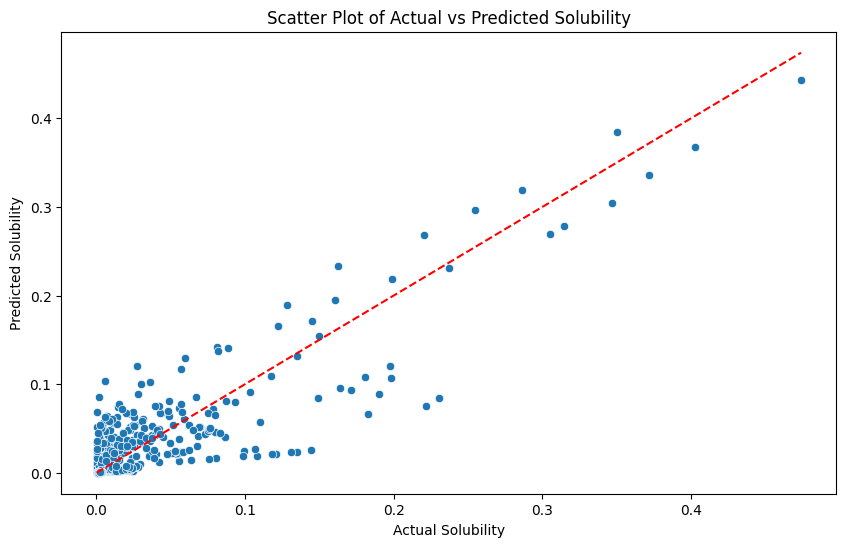

In [ ]:

# Apply the GSE model
gse_preds = gse_model(impd, clnd)

# Save predictions to CSV
gse_preds.to_csv('/content/drive/MyDrive/Sai_Chem_Endsem/gse_predictions.csv', index=False)

# Evaluate by system
systems = gse_preds['System No'].unique()
eval_results = []
predz = pd.read_csv('/content/drive/MyDrive/Sai_Chem_Endsem/gse_predictions.csv')
for sys in systems:
    sys_data = gse_preds[gse_preds['System No'] == sys].copy()

    # Drop NaN values in the relevant columns
    valid_data = sys_data.dropna(subset=['gse_solubility', 'Xs_Exper'])
    y_true = valid_data['Xs_Exper']
    y_pred = valid_data['gse_solubility']

    # Calculate MAE, RMSE, R2
    mae_res = mean_absolute_error(y_true, y_pred)
    rmse_res = np.sqrt(mean_squared_error(y_true, y_pred))
    r2_res = r2_score(y_true, y_pred)

    eval_results.append({
        'System No': sys,
        'MAE': mae_res,
        'RMSE': rmse_res,
        'R2': r2_res
    })

# Convert evaluation results to DataFrame
eval_results_df = pd.DataFrame(eval_results)

# Save evaluation results to CSV
eval_results_df.to_csv('/content/drive/MyDrive/Sai_Chem_Endsem/gse_eval_results.csv', index=False)

# Display evaluation results
print("\nEvaluation Results by System:")
print(eval_results_df)

# Calculate average MAE, RMSE, R2
avg_mae = eval_results_df['MAE'].mean()
avg_rmse = eval_results_df['RMSE'].mean()
avg_r2 = eval_results_df['R2'].mean()

print(f"PREDICTIONS - look at gse_solubility :\n{predz.head()}")

print("\nAverage Metrics:")
print(f"MAE: {avg_mae}")
print(f"RMSE: {avg_rmse}")
print(f"R2: {avg_r2}")

# Create a scatter plot to show actual vs predicted solubility
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Xs_Exper', y='gse_solubility', data=predz)
plt.xlabel('Actual Solubility')
plt.ylabel('Predicted Solubility')
plt.title('Scatter Plot of Actual vs Predicted Solubility')
plt.plot([predz['Xs_Exper'].min(), predz['Xs_Exper'].max()], [predz['Xs_Exper'].min(), predz['Xs_Exper'].max()], color='red', linestyle='--')  # Diagonal line
plt.show()

